In [21]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score,confusion_matrix,log_loss
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor,DMatrix,plot_tree

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train_df_final.csv')
train_df = train_df.fillna(0)
train_df_org = pd.read_csv('train_df_final_blanced.csv')
train_df_org = train_df_org.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

y = train_df['label'].values
y_org = train_df_org['label'].values

In [3]:
base_features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',    
]

base_cat_features = []

cat_cols = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
]

In [4]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [5]:
def get_mean_accuracy(features, cat_features,y):
    train = train_df[features]
    test = test_df[features]
    for each in cat_features:
        train[each] = train[each].values.astype(int)
        test[each] = test[each].values.astype(int)
        
    skf = StratifiedKFold(n_splits=3)
    validation_scores = []
    for train_index, test_index in skf.split(train, y):
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
        test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
        model = CatBoostClassifier(**catboost_params)
        model.fit(X=train_pool, eval_set=test_pool,verbose=0)
        
        validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    return np.mean(validation_scores), np.min(validation_scores)

In [6]:
selected_features = base_features[:]
other_features = [each for each in test_df.columns if each not in selected_features]

In [7]:
mean_accuracy, _ = get_mean_accuracy(base_features,base_cat_features,y)
feature = None

In [8]:
remaining_features = other_features[:]
# remaining_features.remove('predicted_duration_diff_bucket@predicted_avg_speed')
# selected_features.append('predicted_duration_diff_bucket@predicted_avg_speed')

In [9]:
%%time
while len(remaining_features)>0:
    for new_feature in remaining_features:
        features = selected_features + [new_feature]
        cat_features = [feature for feature in features if feature in cat_cols]
        mean,_ = get_mean_accuracy(features,cat_features,y)
        if mean > mean_accuracy:
            mean_accuracy = mean
            feature = new_feature
            print(new_feature, mean)
    if feature != None:
        selected_features.append(feature)
        remaining_features.remove(feature)
        feature = None
    else:
        break

meter_waiting 0.9572106291720495
fare 0.9572695740585805
predicted_fare_diff_per_predicted_fare 0.9577999633991441
predicted_duration_diff_bucket@predicted_avg_speed 0.9579179365454543
is_more_than_one_day 0.9581537056699228
predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance 0.9583304048479877
addtional_fare_per_duration_mean_diff 0.958448367572642
CPU times: user 6h 30min 21s, sys: 17min 59s, total: 6h 48min 20s
Wall time: 58min 10s


In [10]:
selected_features

['fare_per_distance',
 'fare_per_duration',
 'avg_speed',
 'meter_waiting_per_duration',
 'meter_waiting_fare_per_meter_waiting',
 'meter_waiting_fare_per_duration',
 'addtional_fare_per_fare',
 'addtional_fare_per_distance',
 'addtional_fare_per_duration',
 'fare-additional_fare_per_distance',
 'fare-additional_fare_per_duration',
 'fare-additional_fare-meter_waiting_fare_per_distance',
 'fare-additional_fare-meter_waiting_fare_per_duration',
 'meter_waiting_till_pickup_per_meter_waiting',
 'meter_waiting_after_pickup_per_duration',
 'meter_waiting_till_pickup_per_duration',
 'meter_waiting_till_pickup_per_distance',
 'meter_waiting_after_pickup_per_distance',
 'meter_waiting_till_pickup_per_fare',
 'meter_waiting_after_pickup_per_fare',
 'meter_waiting_till_pickup_per_meter_waiting_fare',
 'meter_waiting_after_pickup_per_meter_waiting_fare',
 'predicted_duration_diff_bucket@predicted_avg_speed',
 'addtional_fare_per_duration_mean_diff']

In [11]:
features = selected_features[:]
cat_features = [feature for feature in features if feature in cat_cols]

In [12]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

In [13]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [14]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9700138	test: 0.9663603	best: 0.9663603 (0)	total: 17.9ms	remaining: 17.9s
10:	learn: 0.9725434	test: 0.9732773	best: 0.9745010 (9)	total: 204ms	remaining: 18.3s
20:	learn: 0.9747554	test: 0.9772292	best: 0.9772292 (20)	total: 398ms	remaining: 18.5s
30:	learn: 0.9757799	test: 0.9779609	best: 0.9782546 (29)	total: 596ms	remaining: 18.6s
40:	learn: 0.9763441	test: 0.9782463	best: 0.9782546 (29)	total: 774ms	remaining: 18.1s
50:	learn: 0.9768042	test: 0.9782421	best: 0.9783400 (43)	total: 962ms	remaining: 17.9s
60:	learn: 0.9772227	test: 0.9783400	best: 0.9784379 (53)	total: 1.15s	remaining: 17.8s
70:	learn: 0.9776373	test: 0.9783317	best: 0.9784379 (53)	total: 1.34s	remaining: 17.6s
80:	learn: 0.9783463	test: 0.9784131	best: 0.9786173 (74)	total: 1.52s	remaining: 17.3s
90:	learn: 0.9786806	test: 0.9787928	best: 0.9788949 (83)	total: 1.73s	remaining: 17.3s
100:	learn: 0.9788682	test: 0.9791687	best: 0.9791687 (99)	total: 1.92s	remaining: 17s
110:	

In [15]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.958448367572642, 0.004643752598209992, 0.9519009725906278)

In [16]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9557691938671732, 0.0005951705877332196, 0.9552127108399056)

In [19]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

# PCA

In [40]:
features = test_df.columns
X_train = train_df[features].values
X_train_org = train_df_org[features].values
X_test = test_df[features].values

In [41]:
pca = PCA(n_components=40)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
X_train_org_transformed = pca.transform(X_train_org)

In [42]:
pca_train = pd.DataFrame()
pca_train['label'] = train_df['label']

pca_train_org = pd.DataFrame()
pca_train_org['label'] = y_org

pca_test = pd.DataFrame()
for i in range(40):
    name = f'col_{i}'
    pca_train[name] = X_train_transformed[:,i]
    pca_test[name] = X_test_transformed[:,i]
    pca_train_org[name] = X_train_org_transformed[:,i]
    
pca_train.to_csv('pca_train.csv',index=False)
pca_test.to_csv('pca_test.csv',index=False)

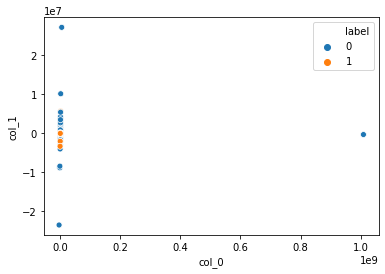

In [31]:
sns.scatterplot(x='col_0',y='col_1',data=pca_train,hue='label')

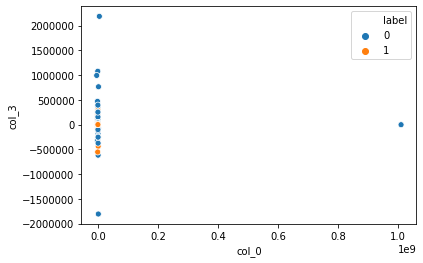

In [38]:
sns.scatterplot(x='col_0',y='col_3',data=pca_train,hue='label')

In [44]:
features = pca_test.columns
cat_features = []

In [45]:
train = pca_train[features]
test = pca_test[features]
train_org = pca_train_org[features]
y = pca_train['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

In [46]:
submission_pool = Pool(data=pca_test[features], cat_features=cat_features)
org_pool = Pool(data=pca_train_org[features], cat_features=cat_features)

In [47]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9674941	test: 0.9686263	best: 0.9686263 (0)	total: 31.4ms	remaining: 31.4s
10:	learn: 0.9705924	test: 0.9683791	best: 0.9688509 (3)	total: 178ms	remaining: 16s
20:	learn: 0.9732946	test: 0.9730091	best: 0.9730091 (20)	total: 319ms	remaining: 14.9s
30:	learn: 0.9749142	test: 0.9740160	best: 0.9740210 (29)	total: 436ms	remaining: 13.6s
40:	learn: 0.9759335	test: 0.9754930	best: 0.9754930 (40)	total: 574ms	remaining: 13.4s
50:	learn: 0.9770598	test: 0.9760445	best: 0.9761471 (48)	total: 692ms	remaining: 12.9s
60:	learn: 0.9774760	test: 0.9766104	best: 0.9766104 (60)	total: 825ms	remaining: 12.7s
70:	learn: 0.9783202	test: 0.9762087	best: 0.9766104 (60)	total: 942ms	remaining: 12.3s
80:	learn: 0.9786501	test: 0.9765880	best: 0.9766862 (74)	total: 1.08s	remaining: 12.3s
90:	learn: 0.9796446	test: 0.9764762	best: 0.9766862 (74)	total: 1.21s	remaining: 12.1s
100:	learn: 0.9803038	test: 0.9764672	best: 0.9766862 (74)	total: 1.34s	remaining: 12s
110:	le

In [48]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9540868836788946, 0.005547453732173097, 0.9462422634836428)

In [49]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9523919175637557, 0.001769352953348763, 0.9508376029013874)